# Camera calibration using CHARUCO

In [17]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 1.  Marker dictionary creation

<IPython.core.display.Javascript object>


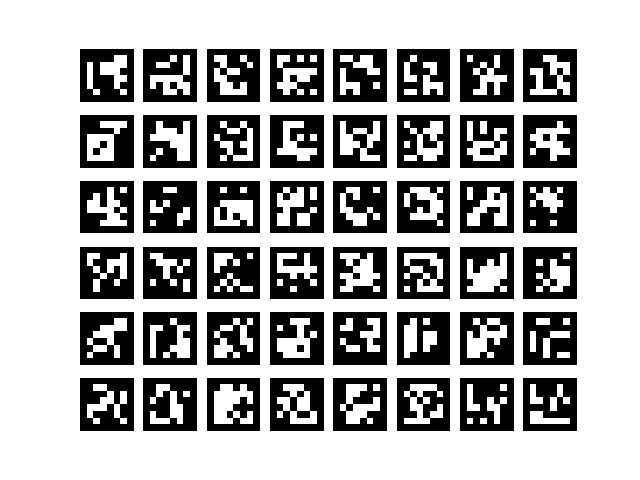

In [18]:
workdir = "data/"

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig(workdir + "markers.pdf")    
plt.show()
#plt.close()

## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


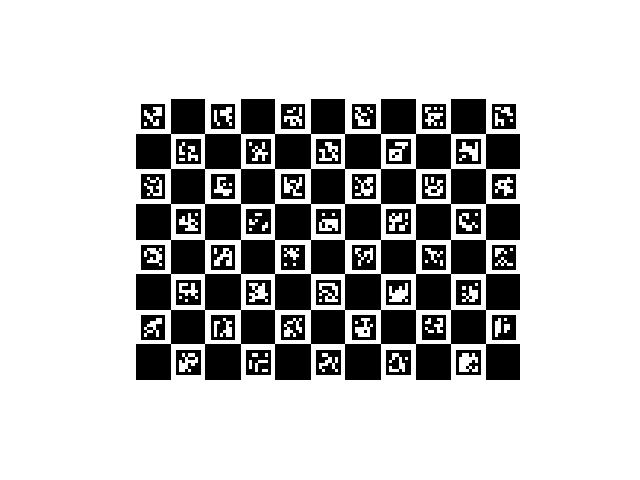

In [19]:
board = aruco.CharucoBoard_create(11, 8, 10, 7, aruco_dict)
imboard = board.draw((500, 500))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.savefig(workdir + "chessboard.pdf")    
plt.show()


And take photos of it from multiple angles, for example:

<IPython.core.display.Javascript object>


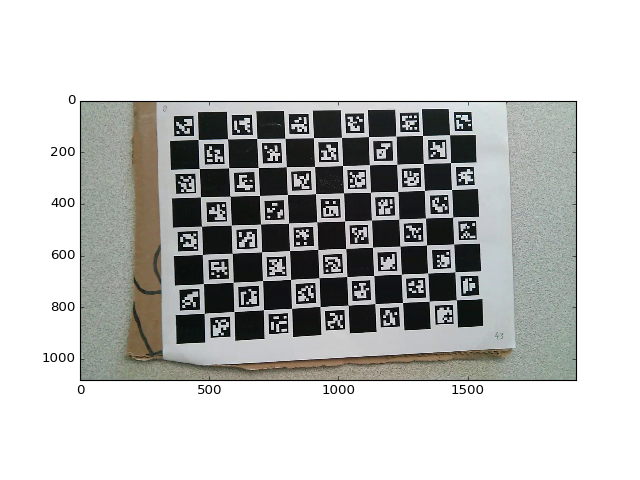

In [20]:
images = [workdir + f for f in os.listdir(workdir) if f.endswith(".png") and f.startswith("VID_20180314_141424")]

im = PIL.Image.open(images[10])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [21]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    
    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              

        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [22]:
%%time

allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image data/VID_20180314_141424_290.png
=> Processing image data/VID_20180314_141424_260.png
=> Processing image data/VID_20180314_141424_370.png
=> Processing image data/VID_20180314_141424_30.png
=> Processing image data/VID_20180314_141424_320.png
=> Processing image data/VID_20180314_141424_150.png
=> Processing image data/VID_20180314_141424_210.png
=> Processing image data/VID_20180314_141424_250.png
=> Processing image data/VID_20180314_141424_200.png
=> Processing image data/VID_20180314_141424_60.png
=> Processing image data/VID_20180314_141424_80.png
=> Processing image data/VID_20180314_141424_70.png
=> Processing image data/VID_20180314_141424_380.png
=> Processing image data/VID_20180314_141424_240.png
=> Processing image data/VID_20180314_141424_330.png
=> Processing image data/VID_20180314_141424_180.png
=> Processing image data/VID_20180314_141424_130.png
=> Processing image data/VID_20180314_141424_390.png
=> Processing image data/V

In [23]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [24]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 3.41 s, sys: 4.33 s, total: 7.74 s
Wall time: 2.16 s


In [25]:
ret

1.5024097274544286

In [26]:
mtx

array([[1.77908014e+03, 0.00000000e+00, 9.74041424e+02],
       [0.00000000e+00, 1.78237118e+03, 5.41836050e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [27]:
dist

array([[ 9.72775277e+00],
       [-2.44821233e+02],
       [ 2.21677313e-03],
       [-4.13184688e-03],
       [ 1.69192175e+03],
       [ 9.34768392e+00],
       [-2.40467367e+02],
       [ 1.66736591e+03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Check calibration results

<IPython.core.display.Javascript object>


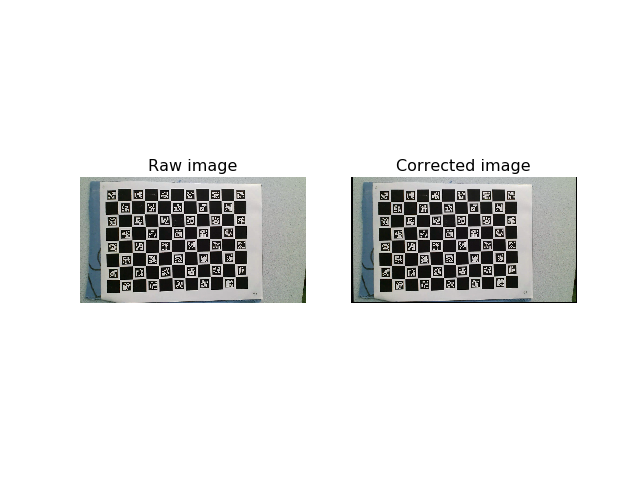

In [32]:
i=3 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

In [31]:

#frame = cv2.imread("data/" + im)
frame = cv2.undistort(frame,mtx,dist,None)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

error: /feedstock_root/build_artefacts/opencv_1497784813564/work/opencv-3.2.0/modules/imgproc/src/undistort.cpp:193: error: (-215) dst.data != src.data in function undistort


## Post processing

In [33]:
%%time

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)


CPU times: user 180 ms, sys: 8 ms, total: 188 ms
Wall time: 141 ms


Very fast processing !

## Results

<IPython.core.display.Javascript object>


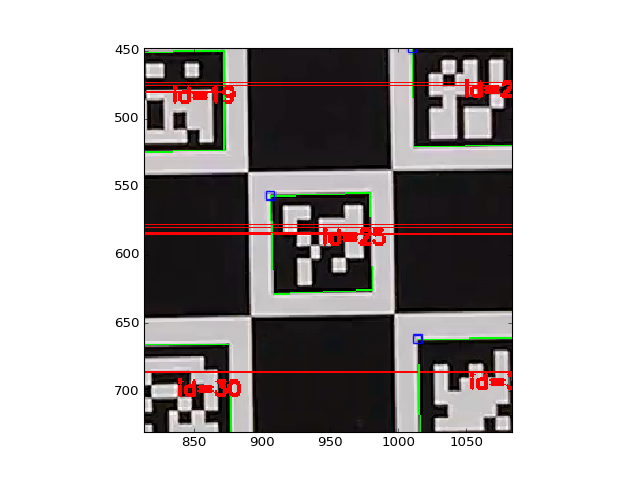

In [34]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [35]:
size_of_marker =  0.0145 # side lenght of the marker in meter
rvecs,tvecs = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [36]:
tvecs

array([[[-0.11488491,  0.07818071,  0.36124855]],

       [[-0.06925335,  0.07565945,  0.35390468]],

       [[-0.02533774,  0.07270371,  0.34532779]],

       [[ 0.0168039 ,  0.07553823,  0.36368482]],

       [[ 0.05977366,  0.07414296,  0.36346671]],

       [[ 0.07775903,  0.05001225,  0.34922815]],

       [[-0.11261559,  0.03328044,  0.35190194]],

       [[-0.0691218 ,  0.03227454,  0.34909306]],

       [[-0.02571596,  0.0304124 ,  0.33846427]],

       [[ 0.05909345,  0.030906  ,  0.36389596]],

       [[-0.0960833 ,  0.01183853,  0.36938646]],

       [[ 0.03564457,  0.00894678,  0.34756765]],

       [[-0.11471344, -0.0095496 ,  0.35564636]],

       [[-0.09125285, -0.03085563,  0.3471609 ]],

       [[-0.06761963, -0.05004116,  0.33318337]],

       [[-0.08980997, -0.07158478,  0.33890713]],

       [[-0.00605488,  0.00991987,  0.35379221]],

       [[-0.04851039, -0.07181356,  0.3393816 ]],

       [[-0.12923757,  0.05320623,  0.33944024]],

       [[-0.08721542,  0.052243

In [37]:
rvecs

array([[[ 3.09121803e+00, -4.01987509e-02,  1.71178093e-01]],

       [[-3.11017069e+00,  1.86244565e-02, -7.23001231e-02]],

       [[-3.02843525e+00,  1.96927828e-02, -8.34721923e-02]],

       [[-3.00396716e+00,  8.22994233e-02, -1.37592515e-02]],

       [[-3.11653371e+00,  2.87096226e-02, -6.53505977e-02]],

       [[ 3.04356477e+00,  6.21809572e-04,  3.05568315e-01]],

       [[ 2.78322710e+00, -2.70433172e-02,  8.57190857e-01]],

       [[-3.25897718e+00,  3.85268786e-02, -6.93493420e-01]],

       [[-2.91231539e+00,  7.41277327e-04, -1.58352610e-02]],

       [[ 3.05943620e+00, -2.56437754e-02,  3.49413469e-02]],

       [[ 2.90861488e+00, -3.82372695e-02,  3.91004798e-01]],

       [[-2.92995376e+00,  4.15701983e-02,  6.53105534e-02]],

       [[ 3.15659255e+00, -2.35574535e-02,  1.20887680e-01]],

       [[-2.80294993e+00, -1.89191732e-02, -3.54217386e-01]],

       [[ 3.18423086e+00,  4.74090972e-03, -2.20080200e-01]],

       [[ 3.13987156e+00,  4.68847281e-03,  5.71234926e

In [38]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


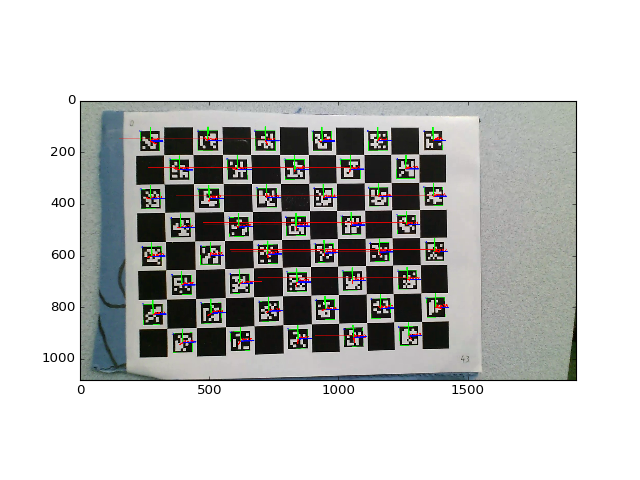

In [39]:
plt.figure()
plt.imshow(imaxis)
plt.show()

In [40]:

data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data



,tx,ty,tz
marker,,,
0,-0.132368,-0.071767,0.341240
1,-0.089810,-0.071585,0.338907
2,-0.048510,-0.071814,0.339382
3,-0.007602,-0.074613,0.351737
4,0.034332,-0.073912,0.348066
5,0.077142,-0.075559,0.355859
6,-0.111154,-0.051024,0.341660
7,-0.067620,-0.050041,0.333183
8,-0.027464,-0.051674,0.341816


<IPython.core.display.Javascript object>


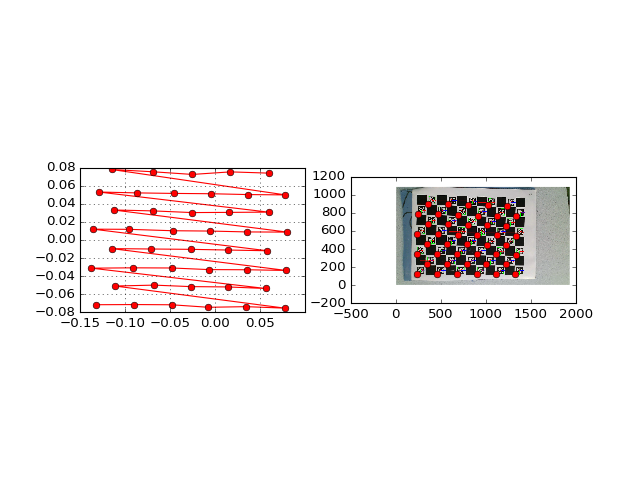

In [41]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "lower")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

<IPython.core.display.Javascript object>


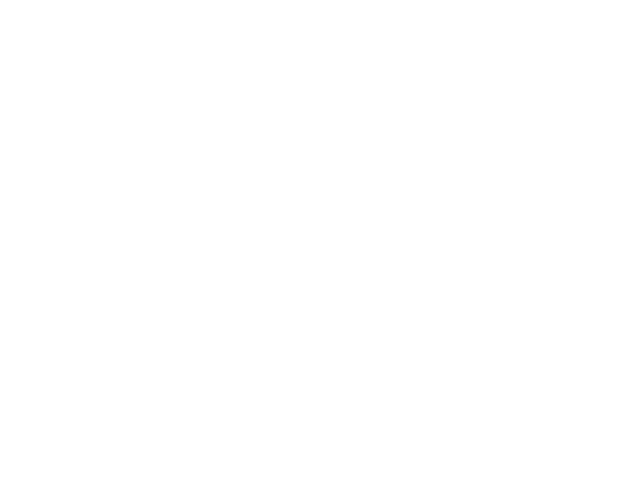

In [307]:
fig = plt.figure()


plt.show()


In [308]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [309]:
import pickle

In [273]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [274]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [310]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,503.0,542.0
1,504.0,952.0
2,498.0,1362.0
3,494.0,1782.0
4,492.0,2198.0
5,491.0,2621.0
6,714.0,757.0
7,711.0,1164.0
8,707.0,1574.0
9,704.0,1987.0


In [321]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


0.043476117957396747

In [347]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [343]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13